# Import Required Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, ConcatDataset

# Load Dataset

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize([14,14]),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
train_set = datasets.MNIST( download=True,  root="./",  transform=transforms_ ,train=True)
test_set = datasets.MNIST(download=True, root="./", transform=transforms_, train=False)
full_set = ConcatDataset([train_set, test_set])
train_loader = DataLoader(full_set, batch_size=64, shuffle=False)

# Define Diffusion Model, Loss Function And Optimizer

In [63]:
class ResLayer(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.SiLU(True),
            nn.BatchNorm1d(128),
            nn.Linear(128, in_features),
            nn.SiLU(True),
        )

    def forward(self, x):
        return self.layer(x) + x
    

class Diffusion(nn.Module):
    def __init__(self, beta_start=1e-4, beta_end=2e-2, num_forward_steps=1000, device='cuda'):
        super().__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_forward_steps = num_forward_steps
        self.device = device
        self.model = nn.Sequential(
                    nn.Linear(196 + num_forward_steps + 10, 512),
                    ResLayer(512),
                    nn.Linear(512, 512),
                    ResLayer(512),
                    nn.Linear(512, 512),
                    ResLayer(512),
                    nn.Linear(512, 196)
                ).to(device)
        beta = torch.linspace(self.beta_start, self.beta_end, self.num_forward_steps).numpy().tolist()
        self.beta = torch.tensor(beta).to(self.device)
        alpha = [1 - beta[0]]
        for i in range(1, self.num_forward_steps):
            alpha.append(alpha[i-1] * (1 - beta[i]))
        self.alpha = torch.tensor(alpha).to(device)

    def forward_process(self, image):
        alpha = self.alpha.repeat(*image.shape, 1).permute(-1, *[i for i in range(len(image.shape))]).to(self.device)
        noise = torch.randn_like(alpha)
        noisy_image = alpha.sqrt() * image +  (1 - alpha).sqrt() * noise
        return noisy_image, noise

    def backward_process(self, noisy_image, label):
        batch_size = noisy_image.shape[1]
        pred_noise = Variable(torch.zeros(self.num_forward_steps, batch_size, 1, 14, 14).to(self.device))
        for t in range(self.num_forward_steps-1, -1, -1):
            noisy_image_batch = noisy_image[t].reshape(batch_size, -1)
            time_one_hot = torch.zeros(batch_size, self.num_forward_steps).to(self.device)
            time_one_hot[:, t] = 1
            noisy_image_batch_with_time = torch.concatenate([noisy_image_batch, time_one_hot, one_hot(label, 10)], dim=1)
            noise_batch = self.model(noisy_image_batch_with_time).view(batch_size, 1, 14, 14)
            pred_noise[t] = noise_batch
        return pred_noise

    def generate(self, label, middle_noise=False):
        images = torch.zeros(self.num_forward_steps + 1, label.shape[0], 196).to(self.device)
        image = torch.randn(label.shape[0], 196).to(self.device)
        images[self.num_forward_steps] = image
        for t in range(self.num_forward_steps-1, -1, -1):
            time_one_hot = torch.zeros(label.shape[0], self.num_forward_steps).to(self.device)
            time_one_hot[:, t] = 1
            image_with_time = torch.concatenate([image, time_one_hot, one_hot(label, 10)], dim=1)
            noise_pred = self.model(image_with_time)
            if middle_noise:
                if t == 0:
                    noise = torch.zeros_like(image)
                else:
                    noise = torch.randn_like(image)
                image = (1 / (1 - self.beta[t]).sqrt()) * (image - ((self.beta[t]) / (1 - self.alpha[t]).sqrt()) * noise_pred) + self.beta[t] * noise
            else:
                image = (1 / (1 - self.beta[t]).sqrt()) * (image - ((self.beta[t]) / (1 - self.alpha[t]).sqrt()) * noise_pred)
            images[t] = image
        return images.view(self.num_forward_steps + 1, label.shape[0], 1, 14, 14).permute(1, 0, 2, 3, 4)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
diffusion = Diffusion(1e-3, 7e-1, 20)
diffusion.load_state_dict(torch.load('diffusion.pth', 'cuda', weights_only=True))
criterion = nn.MSELoss()
optimizer = optim.AdamW(diffusion.parameters(), lr=5e-4)

# Train Diffusion

In [ ]:
for epoch in range(120):
    total_loss = []
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        noisy_image, noise = diffusion.forward_process(data)
        pred_noise = diffusion.backward_process(noisy_image, label)
        loss = criterion(noise, pred_noise)
        total_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch+1}      total {np.mean(total_loss)}')


# Generate Results

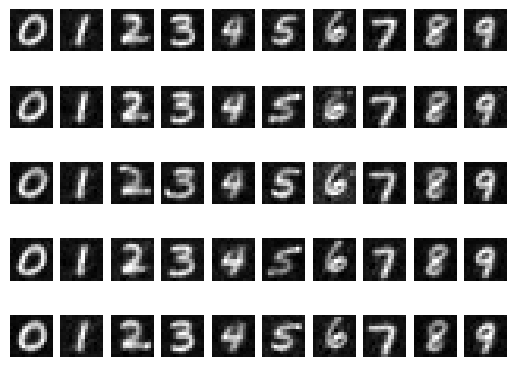

In [ ]:
labels = torch.concatenate([torch.linspace(0, 9, 10).type(torch.LongTensor) for _ in range(5)]).to(device)
images = diffusion.generate(labels)

plt.figure()
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images[i][0].detach().cpu().numpy().reshape(14,14), cmap='gray')
    plt.axis('off')
plt.show()